In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
from wordcloud import WordCloud

In [38]:
# Load caption data
with open('video_caption_sliced.json', 'r') as f:
    video_captions = json.load(f)

In [39]:
with open('video_evaluation_results_1000.json', 'r') as f:
    data = json.load(f)

# Convert to DataFrame    
records = []
for video_id, evaluations in data.items():
    for eval in evaluations:
        records.append({
            'video_id': video_id,  # Truncate ID for readability
            'question': eval['question'],
            'answer': eval['answer'],
            'score': eval['score'],
            'explanation': eval['explanation']
        })
df = pd.DataFrame(records)
df

video_id                                        question  \
0     --Cv4bfGGD8  What is the main activity shown in this video?   
1     --Cv4bfGGD8     Describe the sequence of events that occur.   
2     --Cv4bfGGD8    What are the key objects and people visible?   
3     -CV46fC4olM  What is the main activity shown in this video?   
4     -CV46fC4olM     Describe the sequence of events that occur.   
...           ...                                             ...   
2995  Ry4iDh3KDeY     Describe the sequence of events that occur.   
2996  Ry4iDh3KDeY    What are the key objects and people visible?   
2997  RzRN2uLiUAU  What is the main activity shown in this video?   
2998  RzRN2uLiUAU     Describe the sequence of events that occur.   
2999  RzRN2uLiUAU    What are the key objects and people visible?   

                                                 answer  score  \
0     The main activity shown in this video is the p...     60   
1     The video begins with a close-up of a hand hol...     60   
2     The key objects and people visible are a hand ...     70   
3     The main activity shown in this video is the c...     85   
4     The video begins with a black screen, then tra...     60   
...                                                 ...    ...   
2995  The video begins with a toy gun lying on a red...     60   
2996  The key objects are a toy gun and a green mark...     50   
2997  The main activity shown in this video is the i...     80   
2998  The video begins with a view of an empty room,...     60   
2999  The key objects and people visible are a perso...     70   

                                            explanation  
0     The answer correctly identifies the main activ...  
1     The model's answer captures some key elements ...  
2     The answer correctly identifies several key ob...  
3     The answer accurately describes the main activ...  
4     The answer provides a basic description of the...  
...                                                 ...  
2995  The model's answer provides a basic descriptio...  
2996  The answer correctly identifies the key object...  
2997  The video shows the installation of a transpar...  
2998  The model's answer captures some key elements ...  
2999  The answer correctly identifies the key object...  

[3000 rows x 5 columns]

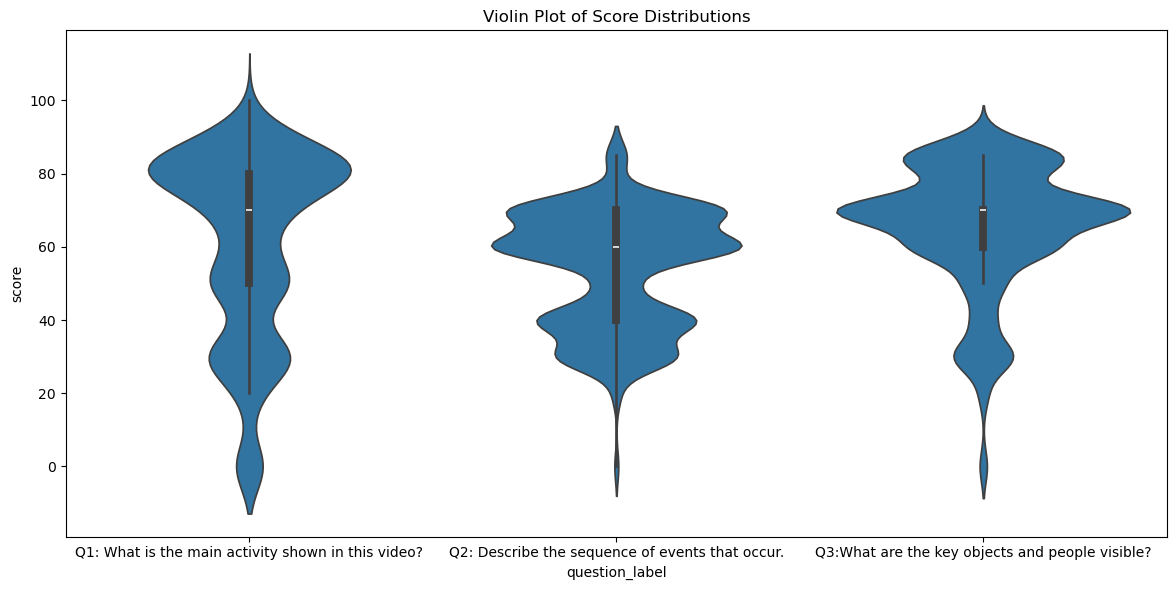

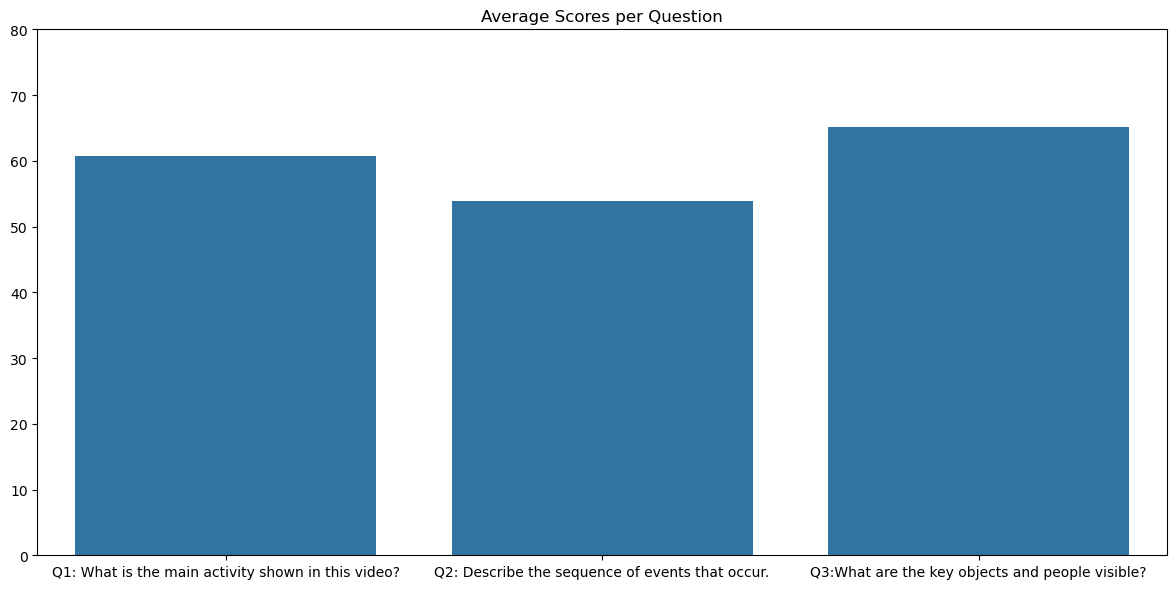

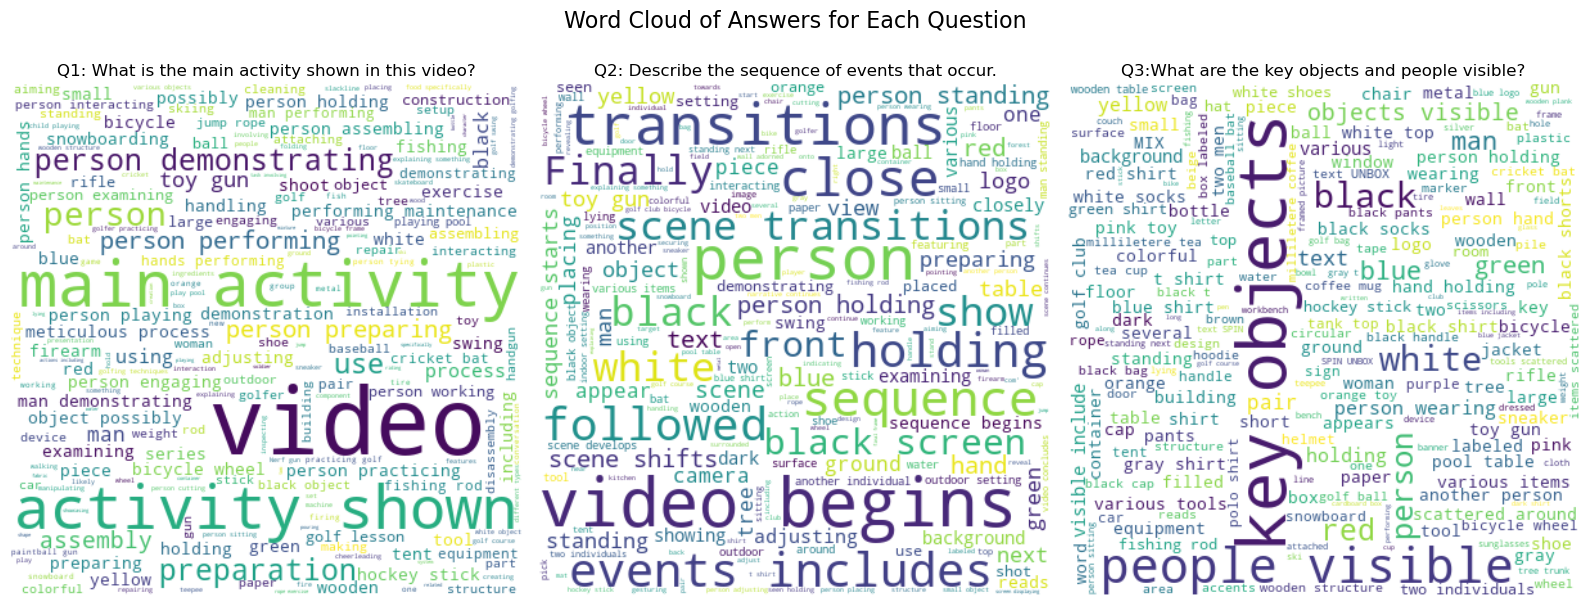

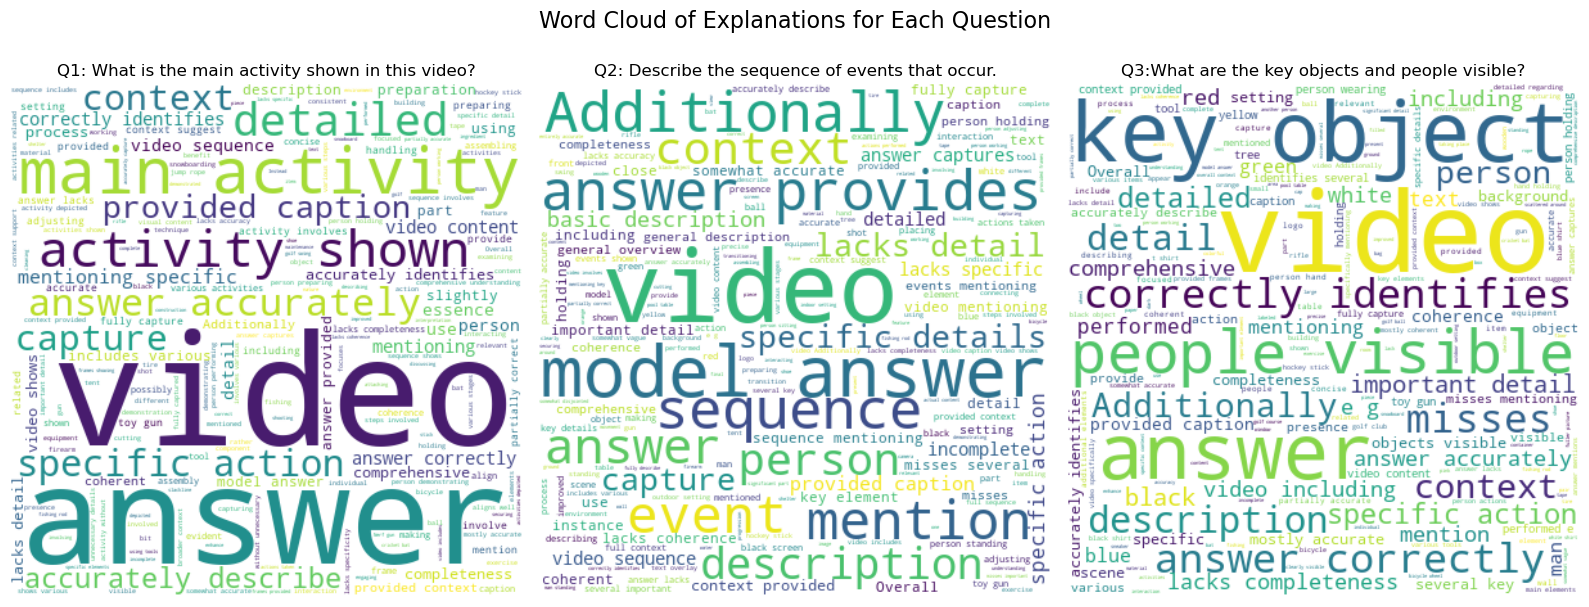

In [40]:
# Define consistent order
question_order = [
    'Q1: What is the main activity shown in this video?',
    'Q2: Describe the sequence of events that occur.',
    'Q3:What are the key objects and people visible?'
]

# Create a mapping dictionary for questions
question_map = {
    'What is the main activity shown in this video?': question_order[0],
    'Describe the sequence of events that occur.': question_order[1],
    'What are the key objects and people visible?': question_order[2]
}

# Create a new column with mapped questions
df['question_label'] = df['question'].map(question_map)

# 3. Violin plot of score distributions
plt.figure(figsize=(12, 6))
sns.violinplot(x='question_label', y='score', data=df, order=question_order)
plt.title('Violin Plot of Score Distributions')
plt.tight_layout()
plt.show()

# 4. Average scores per question
plt.figure(figsize=(12, 6))
avg_scores = df.groupby('question_label')['score'].mean()
sns.barplot(x=question_order, y=[avg_scores[q] for q in question_order])
plt.ylim(0, 80)
plt.title('Average Scores per Question')
plt.tight_layout()
plt.show()

# Word clouds for answers by question type
plt.figure(figsize=(16, 6))
for i, q in enumerate(question_order,1):
    plt.subplot(1, 3, i)
    text_ans = ' '.join(df[df['question_label'] == q]['answer'].astype(str))
    wordcloud = WordCloud(width=400, height=400, background_color='white').generate(text_ans)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{q}')

plt.suptitle('Word Cloud of Answers for Each Question', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# 7. Word clouds for explanations by question type
plt.figure(figsize=(16, 6))
for i, q in enumerate(question_order, 1):
    plt.subplot(1, 3, i)
    text_exp = ' '.join(df[df['question_label'] == q]['explanation'].astype(str))
    wordcloud = WordCloud(width=400, height=400, background_color='white').generate(text_exp)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{q}')

plt.suptitle('Word Cloud of Explanations for Each Question', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

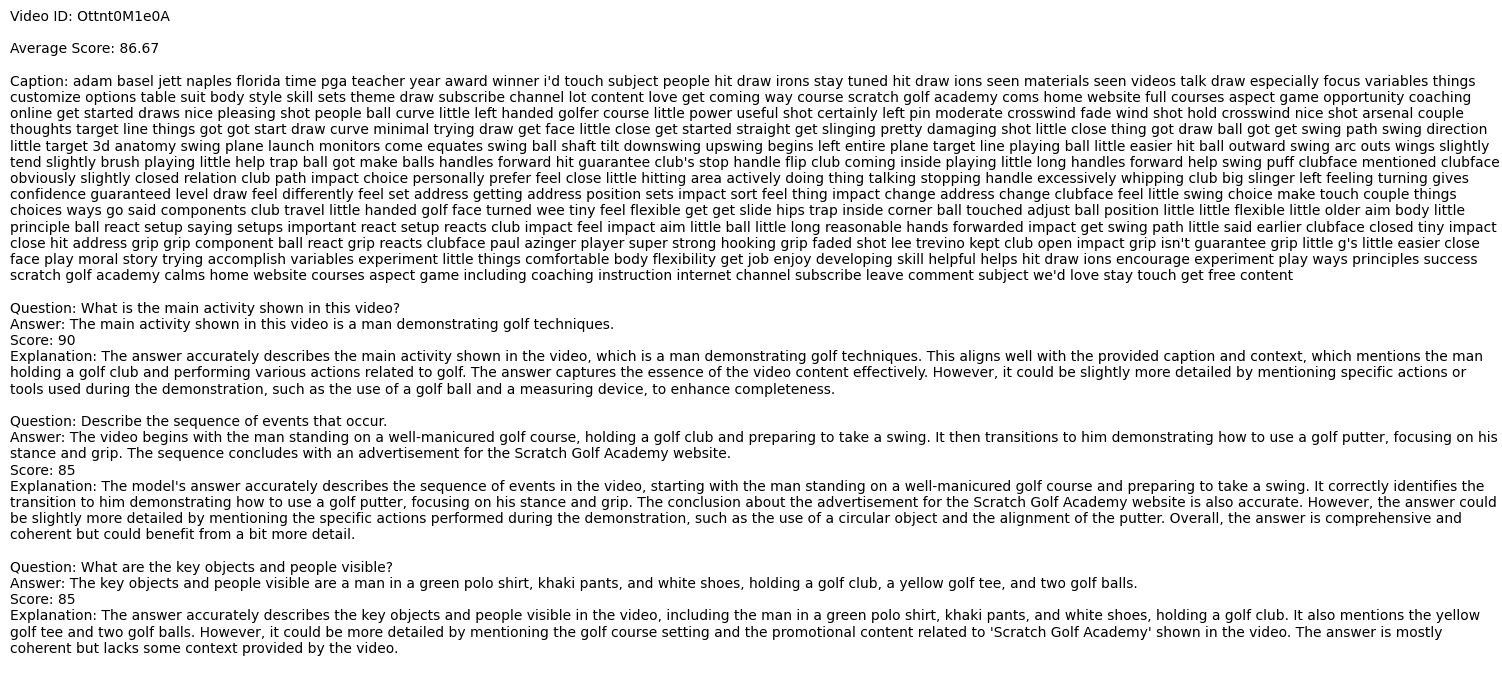

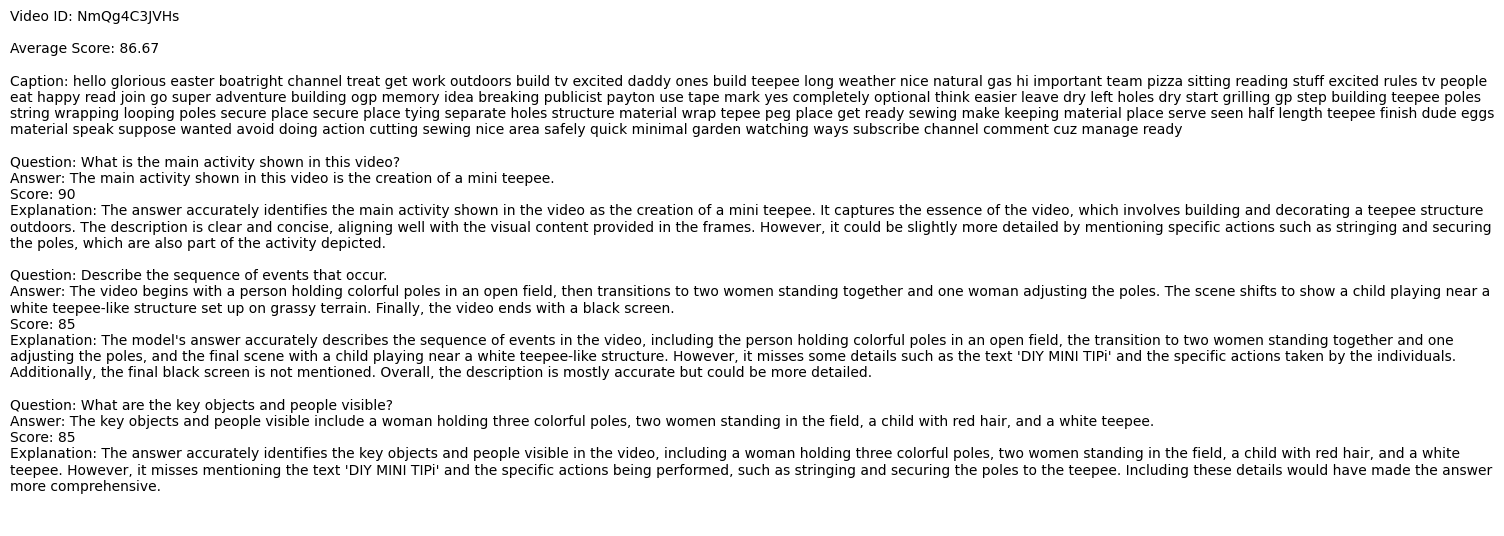

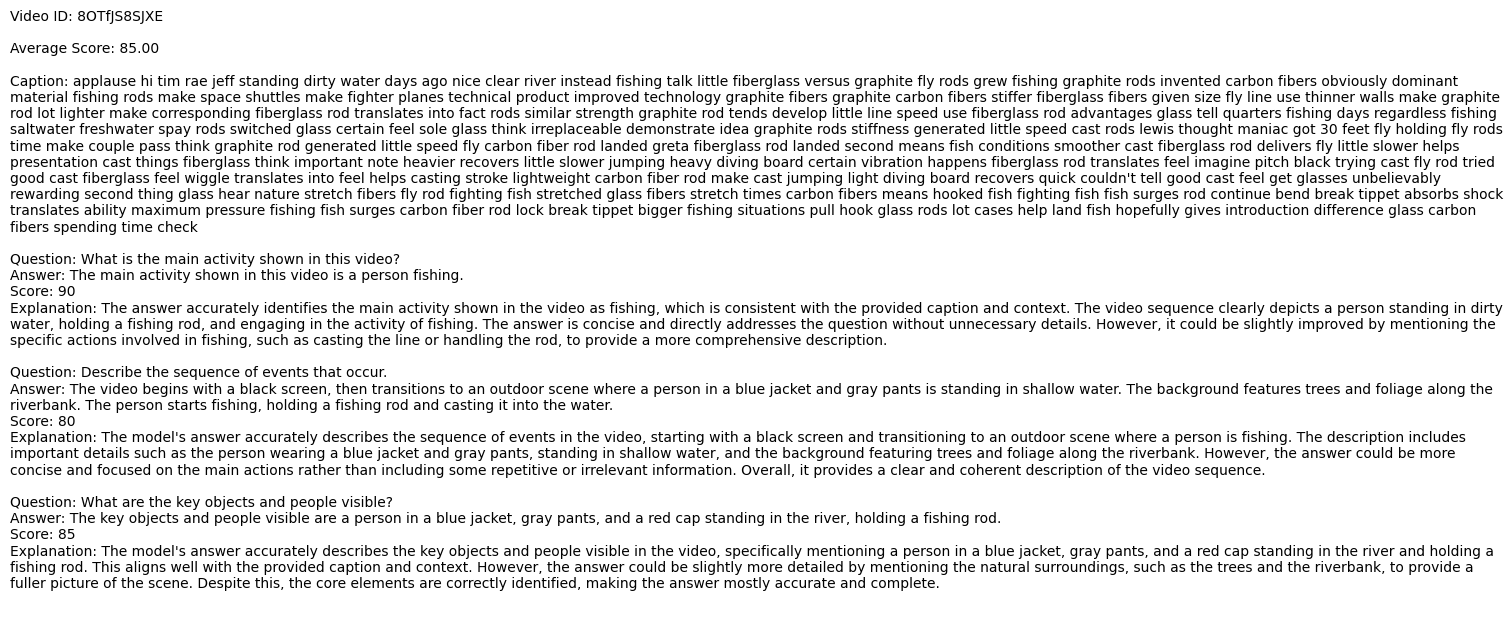

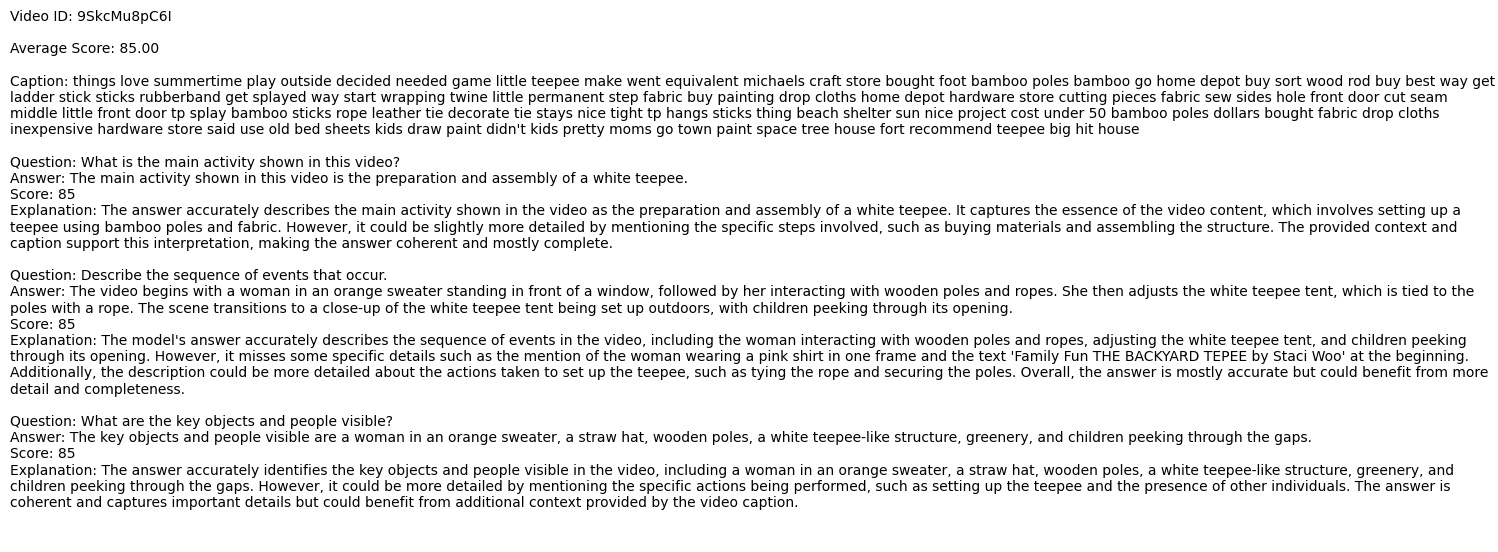

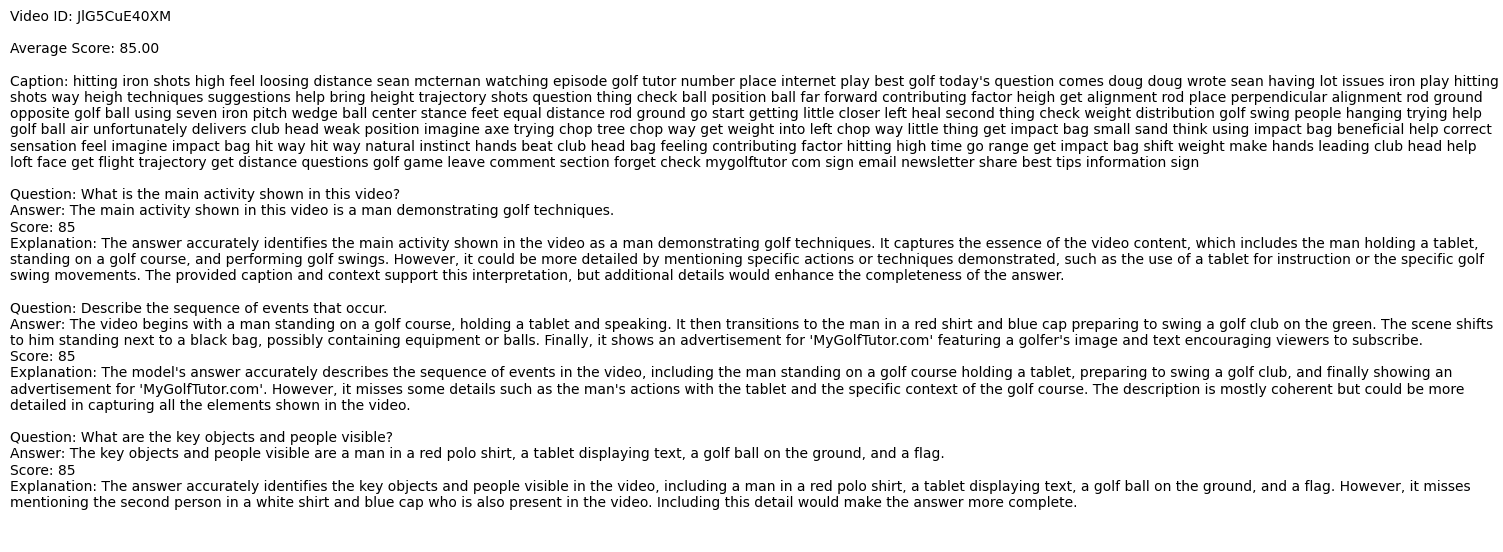

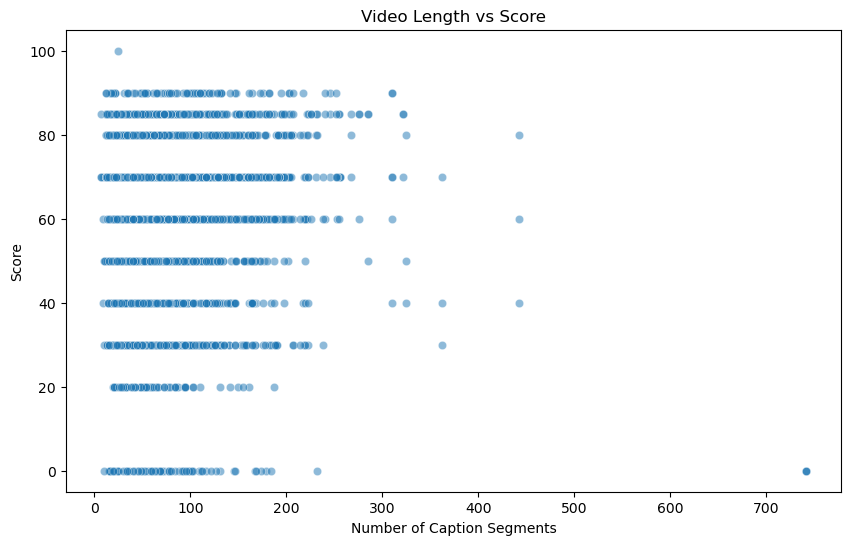

In [54]:
# 1. Find top scoring videos
def get_top_videos(df, n=5):
    video_avg_scores = df.groupby('video_id')['score'].mean().sort_values(ascending=False)
    return video_avg_scores.head(n)

# 2. Create a detailed display for top videos
def display_top_video_details(df, video_captions, n=5):
    top_videos = get_top_videos(df, n)
    
    for video_id, score in top_videos.items():
        plt.figure(figsize=(15, 6))
        
        # Get video details
        video_data = df[df['video_id'] == video_id]
        
        # Get caption
        caption_text = ""
        if video_id in video_captions:
            caption_text = video_captions[video_id]['text']
            if isinstance(caption_text, list):
                caption_text = " ".join(caption_text)
        
        # Create text display
        text = f"Video ID: {video_id}\n\nAverage Score: {score:.2f}\n\n"
        text += f"Caption: {caption_text}\n\n"
        
        # Add Q&A pairs
        for _, row in video_data.iterrows():
            text += f"Question: {row['question']}\n"
            text += f"Answer: {row['answer']}\n" 
            text += f"Score: {row['score']}\n"
            text += f"Explanation: {row['explanation']}\n\n"
        
        plt.text(0, 0, text, wrap=True, fontsize=10)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

# 3. Score distribution by video length
def analyze_video_length_vs_score(df, video_captions):
    video_lengths = {vid: len(cap['text']) for vid, cap in video_captions.items()}
    
    # Create DataFrame with video lengths
    length_scores = pd.DataFrame({
        'video_id': df['video_id'],
        'score': df['score']
    })
    length_scores['caption_length'] = length_scores['video_id'].map(video_lengths)
    
    # Visualize
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=length_scores, x='caption_length', y='score', alpha=0.5)
    plt.title('Video Length vs Score')
    plt.xlabel('Number of Caption Segments')
    plt.ylabel('Score')
    plt.show()


# Generate all visualizations
display_top_video_details(df, video_captions)
analyze_video_length_vs_score(df, video_captions)